<center>

# **TradingVision** : Encoding Candlesticks to GASF 
# Matrices for Pattern Classification Using CNN
#### By: Mohamed BELLOUCH, Data INE3
$$
\\
$$

I tried throughout the sections of this project to implement a trading strategy described in a paper by [Chen and Tsai](https://arxiv.org/abs/1901.05237) on the given Apple data.

Their github repository is available [here](https://github.com/pecu/FinancialVision/tree/master/Encoding%20candlesticks%20as%20images%20for%20patterns%20classification%20using%20convolutional%20neural%20networks), though their code is not well orginized and still consists of several bugs.

## Import data and libraries

In [46]:
%%capture
#@title <font size="3"> Install <b>yfinance</b> and <b>mplfinance</b></font> { vertical-output: true }
!pip install yfinance
!pip install mplfinance;

In [102]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pickle
import multiprocessing as mp
from tqdm import trange, tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import mplfinance as mpf
import requests
from IPython.display import Image

To import files (such as the Apple dataset, the images of the Candlestick patterns ...) from a sharable folder in my drive :

In [47]:
def get_from_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = None
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            token = value
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)
    return destination

Let's import the dataset:

In [48]:
get_from_drive('1kt0YnQyM4giPIactUrCzI2Gnv6ScLj8N', 'AAPL_Daily.csv')
df = pd.read_csv('/content/AAPL_Daily.csv').set_index('Date')
df.index = pd.DatetimeIndex(df.index)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-11-11,0.281071,0.283750,0.270000,0.270714,0.230761,152975200
2002-11-12,0.273571,0.286429,0.272857,0.279286,0.238068,223792800
2002-11-13,0.276786,0.286964,0.272857,0.278393,0.237307,231739200
2002-11-14,0.283929,0.293036,0.281786,0.291071,0.248114,141713600
2002-11-15,0.289821,0.290000,0.281429,0.284821,0.242787,160994400


# 1. Preliminaries and objectives

To make trading decisions, traders often make judgments based on Candlestick pattern recognition, i.e. recognizing and interpreting paterns such as *Morning Star* and *Evening Star*..., which is an essential tool for determining market conditions. Candlestick pattern recognition requires a deliberate analysis of trader expertise rather than pure numerical analysis. This recognition requires traders to make visual judgments on images.

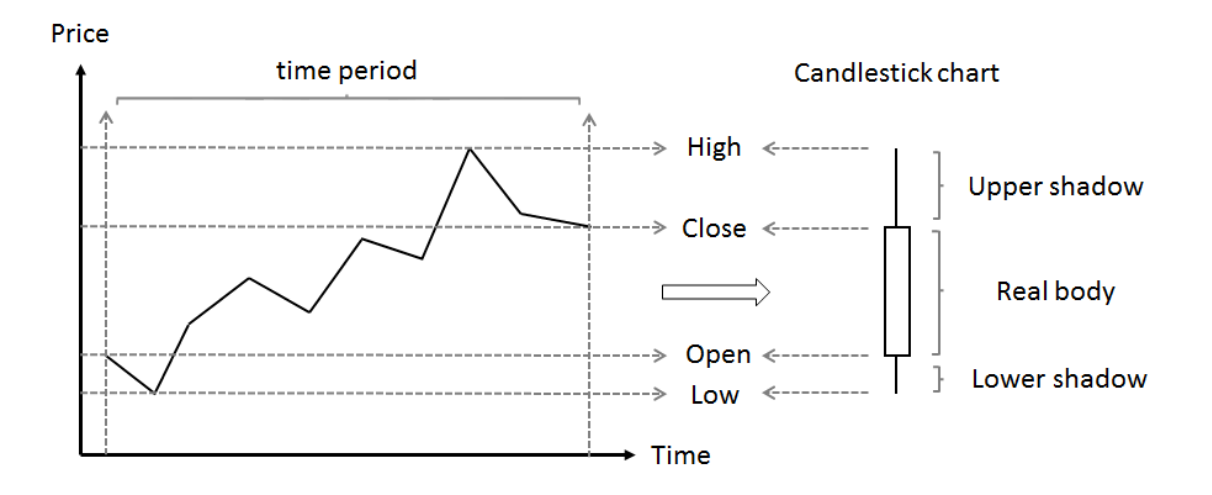

In [49]:
Image(get_from_drive('19Dgo8N1tPrTrdGxtwSWTnjH9ZgAkJnq2', 'img1.png'), width=600, height=280)

A Convolutional Neural Network (CNN) model might be well-suited to such a case, but instead of blindly using any machine learning model we should keep in mind that :

1. Such datasets are always dynamic, and patterns in them are changing.
2. We need to find a way to convert the time-series data into a consistent and more sophisticated matrix form.

I have tried for example applying CNN directly to candlestick charts to extract recognized patterns in an unsupervised learning context, but this does not work well, and still represents a blind use of machine learning as I mentioned earlier.

The paper described a beautiful approach to solve this problem, the authors suggested to use the Gramian Angular Field (GAF) to encode the time-series data from a one-dimensional time-series array to the two-dimensional convolutional time-series matrix, and based on this representation an CNN model will be designed to dectect the patterns.


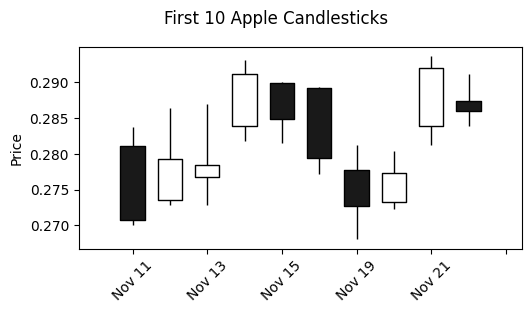

In [67]:
mc = mpf.make_marketcolors(up='white', down='black')
exterior = mpf.make_mpf_style(marketcolors=mc)
k_plot = mpf.plot(df.iloc[:10], style=exterior, type='candle', 
                  volume=False, figratio=(30,14), figscale=0.5, 
                  title='First 10 Apple Candlesticks',)

# 2. Gramian Angular Field

Wang and Oates proposed a novel method to represent time series data in a polar coordinate system and using various operations to convert these angles into symmetry matrix. Particularily, the Gramian Angular Summation Field (GASF) is a kind of GAF where each element of the GASF matrix is the cosine of the summation of angles.

To implement this representation, we will follow the steps described in the paper:

## 2.1. Normalization

Our first step to making a GAF matrix is to normalize the given time series data X into values between [0, 1]. The following equation shows the simple linear normalization method, where notation  ̃xi represents the normalized data. 

$$ \tilde{x_{i}}  = \frac{x_{i} - min(X)}{max(X) - min(X)} $$

## 2.2. Polar Coordinate System representation

After normalization, our second step is to represent the normalized time series data in the polar coordinate system. The following two equations show how to get the angles and radius from the rescaled time series data :

$$ \varphi_{i} = arcos(\tilde{x_{i}}) \qquad  s.t. : \enspace \tilde{x_{i}} \in \tilde{X} \enspace -1 \leq \tilde{x_{i}} \leq 1 $$
and :
$$ r = \frac{t_{i}}{N} \quad s.t.: t_i \in \mathbb{N} $$

\\
The following function returns this representation for a given time series (array-like) input:

In [5]:
def ts_to_GASF(ts, max_v, min_v):
    if max_v == min_v:
        gaf_m = np.zeros((len(ts), len(ts)))
    else:
        ts_nor = np.array((ts-min_v) / (max_v-min_v))
        ts_nor_arc = np.arccos(ts_nor)
        gaf_m = np.zeros((len(ts_nor), len(ts_nor)))
        for r in range(len(ts_nor)):
            for c in range(len(ts_nor)):
                gaf_m[r, c] = np.cos(ts_nor_arc[r] + ts_nor_arc[c])
    return gaf_m

## 2.3. Compute the GASF

Finally, we sum the angles and use the cosine function to make the GASF by the following equation:

$$GASF = cos(\varphi_{i} + \varphi_{j}) = \tilde{X}^T . X - {\sqrt{I - X^2}}^T . {\sqrt{I - X^2}}$$

Hence this function, based on the previous one:

In [6]:
def get_GASF(arr):
    arr = arr.copy()
    gasf = np.zeros((arr.shape[0], arr.shape[1], arr.shape[1], arr.shape[2]))
    for i in range(arr.shape[0]):
        for c in range(arr.shape[2]):
            each_channel = arr[i, :, c]
            c_max = np.amax(each_channel)
            c_min = np.amin(each_channel)
            each_gasf = ts_to_GASF(each_channel, max_v=c_max, min_v=c_min)
            gasf[i, :, :, c] = each_gasf
    return gasf

# 3. Major Candlesticks Signals

A candlestick pattern is a movement in prices shown graphically on a candlestick chart that some believe can predict a particular market movement. The eight candlestick patterns the authors of the paper have chosen are:
* **Morning Star**
* **Bullish Engulfing**
* **Hammer**
* **Shooting Star**
* **Evening Star**
* **Bearish Engulfing**
* **Hanging Man**
* **Inverted Hammer**

Explaining how to detect and interpret each pattern is beyond the scope of my project, but for more in-depth reading, I recommend the well-known book "*The Major Candlestick Signals*".

## 3.1. The Morning Star signal

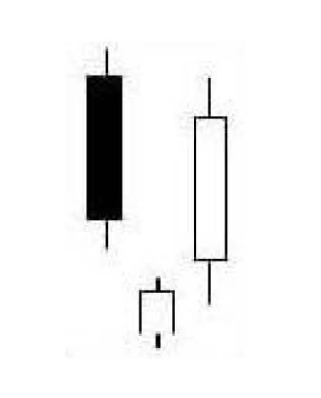

In [7]:
Image(get_from_drive('18mkCQOdN8AJ5pQ8DfxDj2YkHH2lZCRk9', 'morning_star.png'), width=230, height=230)

The criteria on which a Morning Star is detected are the following:
1. The downtrend has been apparent.
2. The body of the first candle is black, continuing the current trend. The second candle is an indecision formation.
3. The third day shows evidence that the bulls have stepped in. That candle should close at least halfway up the black candle.

The function below detects these patterns, the short_per and long_per are determination percentiles mentioned in the article.

In [8]:
def detect_morning_star(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting morning star')
    temp = data[(data['previous_trend'] == -1) & (data['direction'] == -1)].index
    data['morning'] = 0
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'body_per'] >= long_per)
            cond2 = (data.loc[idx+1, 'body_per'] <= short_per)
            cond3 = (data.loc[idx+2, 'direction'] == 1)
            # cond4 = max(data.loc[idx+1, 'close'], data.loc[idx+1, 'open']) <= data.loc[idx, 'close']
            cond4 = (data.loc[idx+1, 'Close'] + data.loc[idx+1, 'Open'])/2 <= data.loc[idx, 'Close']
            cond5 = data.loc[idx+2, 'Close'] >= ((data.loc[idx, 'Open'] + data.loc[idx, 'Close'])/2)
            # cond6 = (data.loc[idx+2, 'body_per'] >= long_per)
            cond7 = (data.loc[idx+2, 'Open'] >= (data.loc[idx+1, 'Open'] + data.loc[idx+1, 'Close'])/2)
            if cond1 & cond2 & cond3 & cond4 & cond5 & cond7:
                data.loc[idx+2, 'morning'] = 1
    except:
        pass

    if multi:
        q.put({'morning': np.array(data['morning'])})
    else:
        return data

## 3.2. Evening Star

The Evening Star pattern is a top reversal signal. It is exactly the opposite of the Morning Star signal. 

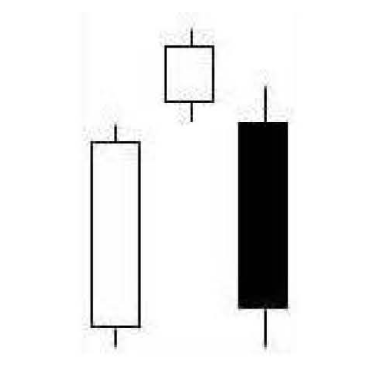

In [9]:
Image(get_from_drive('1ZFjJvrPaEt4lm8H_1NwEb9QuGaHtnFla', 'evening_star.png'), width=230, height=230)

The criteria on which an Evening Star is detected are the following:
1. The uptrend has been apparent.
2. The body of the first candle is white, continuing the current trend. The second candle is an
indecision formation.
3. The third day shows evidence that the bears have stepped in. That candle should close at
least halfway down the white candle.

In [10]:
def detect_evening_star(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting evening star')
    temp = data[(data['previous_trend'] == 1) & (data['direction'] == 1)].index
    data['evening'] = 0
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'body_per'] >= long_per)
            cond2 = (data.loc[idx+1, 'body_per'] <= short_per)
            cond3 = (data.loc[idx+2, 'direction'] == -1)
            cond4 = (data.loc[idx+1, 'Close'] + data.loc[idx+1, 'Open'])/2 >= data.loc[idx, 'Close']
            cond5 = data.loc[idx+2, 'close'] <= ((data.loc[idx, 'Open'] + data.loc[idx, 'Close'])/2)
            # cond6 = (data.loc[idx+2, 'body_per'] >= long_per)
            cond7 = (data.loc[idx+2, 'Open'] <= (data.loc[idx+1, 'Open'] + data.loc[idx+1, 'Close'])/2)
            if cond1 & cond2 & cond3 & cond4 & cond5 & cond7:
                data.loc[idx+2, 'evening'] = 1
    except:
        pass

    if multi:
        q.put({'evening': np.array(data['evening'])})
    else:
        return data

## 3.3. Shooting Star

The Shooting Star is comprised of one candle. It is easily identified by the presence of a small
body with a shadow at least two times greater than the body. It is found at the top of an
uptrend. 

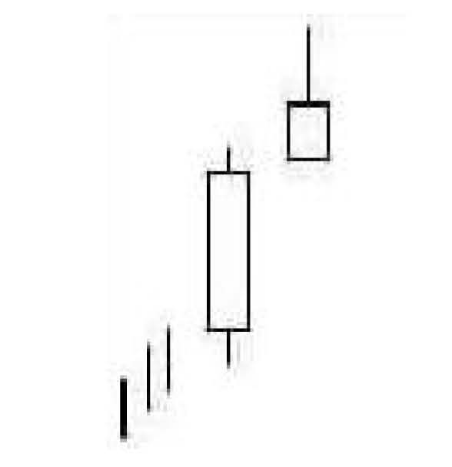

In [11]:
Image(get_from_drive('1gNh5bCsJruDQsZJ92DRLH22jjhnK3A6u', 'shooting_star.png'), width=230, height=230)

1. The upper shadow should be at least two times the length of the body.
2. The real body is at the lower end of the trading range. The color of the body is not
important although a black body should have slightly more bearish implications.
3. There should be no lower shadow or a very small lower shadow.
4. The following day needs to confirm the Shooting Star signal with a black candle or better
yet, a gap down with a lower close

In [12]:
def detect_shooting_star(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting shooting star')
    data['shooting_star'] = 0
    temp = data[(data['previous_trend'] == 1) & (data['direction'] == 1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'body_per'] >= long_per)
            cond2 = (data.loc[idx, 'direction'] == 1)
            cond3 = (data.loc[idx+1, 'ushadow_width'] > 2 * abs(data.loc[idx+1, 'diff']))
            cond4 = (min(data.loc[idx+1, 'Open'], data.loc[idx+1, 'Close']) > ((data.loc[idx, 'Close'] + data.loc[idx, 'Open']) / 2))
            cond5 = (data.loc[idx+1, 'lower_per'] <= short_per - 10)  # 25
            cond6 = (data.loc[idx+1, 'upper_per'] >= long_per)
            if cond1 & cond2 & cond3 & cond4 & cond5 & cond6:
                data.loc[idx+1, 'shooting_star'] = 1
    except:
        pass

    if multi:
        q.put({'shooting_star': np.array(data['shooting_star'])})
    else:
        return data

## 3.4. Hanging Man

The Hanging Man is also comprised of one candle. It is easily identified by the presence of a small body with a shadow at least two times greater than the body. It is found at the top of an up trend.

1. The upper shadow should be at least two times the length of the body.
2. The real body is at the upper end of the trading range. The color of the body is not
important although a black body should have slightly more bearish implications.
3. There should be no upper shadow or a very small upper shadow.
4. The following day needs to confirm the Hanging Man signal with a black candle or better
yet, a gap down with a lower close.

In [13]:
def detect_hanging_man(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting hanging man')
    data['hanging_man'] = 0
    temp = data[(data['previous_trend'] == 1) & (data['direction'] == 1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'lshadow_width'] > 2 * abs(data.loc[idx, 'diff']))
            cond2 = (data.loc[idx, 'body_per'] <= short_per)
            cond3 = (data.loc[idx, 'upper_per'] <= (short_per - 10))
            cond4 = (data.loc[idx, 'lower_per'] >= long_per)
            if cond1 & cond2 & cond3 & cond4:
                data.loc[idx, 'hanging_man'] = 1
    except:
        pass

    if multi:
        q.put({'hanging_man': np.array(data['hanging_man'])})
    else:
        return data

## 3.5. Bullish Engulfing

1. The body of the second day completely engulfs the body of the first day. Shadows are not a
consideration.
2. Prices have been in a definable down trend, even if it has been short term.
3. The body of the second candle is opposite color of the first candle, the first candle being the
color of the previous trend. The exception to this rule is when the engulfed body is a doji or an
extremely small body

In [14]:
def detect_bullish_engulfing(data, q=None, multi=False, short_per=35, long_per=65):
    '''Detect bullish engulfing pattern
    Args:
        short_per (int): percentile for determination.
        long_per (int): percentile for determination.
    
    Returns:
        dataframe.
    '''
    print('[ Info ] : detecting bullish engulfing')
    data['bullish_engulfing'] = 0
    temp = data[(data['previous_trend'] == -1) & (data['direction'] == -1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'direction'] == -1)
            cond2 = (data.loc[idx, 'body_per'] >= long_per)
            cond3 = (data.loc[idx+1, 'direction'] == 1)
            cond4 = (data.loc[idx+1, 'Close'] > data.loc[idx, 'Open'])
            cond5 = (data.loc[idx+1, 'Open'] < data.loc[idx, 'Close'])
            if cond1 & cond2 & cond3 & cond4 & cond5:
                data.loc[idx+1, 'bullish_engulfing'] = 1
    except:
        pass

    if multi:
        q.put({'bullish_engulfing': np.array(data['bullish_engulfing'])})
    else:
        return data

## 3.6. Hammer

1. The lower shadow should be at least two times the length of the body.
2. The real body is at the upper end of the trading range. The color of the body is not
important although a white body should have slightly more bullish implications.
3. There should be no upper shadow or a very small upper shadow.

In [15]:
def detect_hammer(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting hammer')
    data['hammer'] = 0
    temp = data[(data['previous_trend'] == -1) & (data['direction'] == -1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'lshadow_width'] > 2 * abs(data.loc[idx, 'diff']))
            cond2 = (data.loc[idx, 'body_per'] <= short_per)
            cond3 = (data.loc[idx, 'upper_per'] <= (short_per - 15))
            cond4 = (data.loc[idx, 'lower_per'] >= long_per)
            if cond1 & cond2 & cond3 & cond4:
                data.loc[idx, 'hammer'] = 1
    except:
        pass

    if multi:
        q.put({'hammer': np.array(data['hammer'])})
    else:
        return data

## 3.7. Inverted Hammer


1. The upper shadow should be at least two times the length of the body.
2. The real body is at the lower end of the trading range. The color of the body is not
important, although a white body should have slightly more bullish implications.
3. There should be no lower shadow, or a very small lower shadow.

In [16]:
def detect_inverted_hammer(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting inverted hammer')
    data['inverted_hammer'] = 0
    temp = data[(data['previous_trend'] == -1) & (data['direction'] == -1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'direction'] == -1)
            cond2 = (data.loc[idx, 'body_per'] >= long_per)
            cond3 = (data.loc[idx+1, 'ushadow_width'] > 2 * abs(data.loc[idx+1, 'diff']))
            cond4 = (max(data.loc[idx+1, 'Open'], data.loc[idx+1, 'Close']) < ((data.loc[idx, 'Close'] + data.loc[idx, 'Open']) / 2))
            cond5 = (data.loc[idx+1, 'lower_per'] <= short_per)
            cond6 = (data.loc[idx+1, 'upper_per'] >= long_per)
            if cond1 & cond2 & cond3 & cond4 & cond5 & cond6:
                data.loc[idx+1, 'inverted_hammer'] = 1
    except:
        pass

    if multi:
        q.put({'inverted_hammer': np.array(data['inverted_hammer'])})
    else:
        return data 

## 3.8. Bullish Harami

1. The body of the first candle is black, the body of the second candle is white.
2. The downtrend has been evident for a good period. A long black candle occurs at the end
of the trend.
3. The second day opens higher than the close of the previous day and closes lower than the
open of the prior day.
4. Unlike the Western "Inside Day", just the body needs to remain in the previous day's body,
where as the "Inside Day" requires both the body and the shadows to remain inside the
previous day's body.
5. For a reversal signal, further confirmation is required to indicate that the trend is now
moving up.

In [17]:
def detect_bullish_harami(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting bullish harami')
    data['bullish_harami'] = 0
    temp = data[(data['previous_trend'] == -1) & (data['direction'] == -1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'direction'] == -1)
            cond2 = (data.loc[idx, 'body_per'] >= long_per)
            cond3 = (data.loc[idx+1, 'direction'] == 1)
            cond4 = (data.loc[idx+1, 'Close'] >= ((data.loc[idx, 'Open'] + data.loc[idx, 'Close'])/2))
            cond5 = (data.loc[idx+1, 'Close'] < data.loc[idx, 'Open'])
            cond6 = (data.loc[idx+1, 'Open'] > data.loc[idx, 'Close'])
            cond7 = (data.loc[idx+1, 'Open'] <= ((data.loc[idx, 'Open'] + data.loc[idx, 'Close'])/2))
            cond8 = (data.loc[idx+1, 'body_per'] >= long_per)
            if cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8:
                data.loc[idx+1, 'bullish_harami'] = 1
    except:
        pass

    if multi:
        q.put({'bullish_harami': np.array(data['bullish_harami'])})
    else:
        return data    

## 3.9. Bearish Hammer

1. The body of the first candle is white; the body of the second candle is black.
2. The uptrend has been apparent. A long white candle occurs at the end of the trend.
3. The second day opens lower than the close of the previous day and closes higher than the
open of the prior day.
4. For a reversal signal, confirmation is needed. The next day should show weakness.

In [18]:
def detect_bearish_harami(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting bearish harami')
    data['bearish_harami'] = 0
    temp = data[(data['previous_trend'] == 1) & (data['direction'] == 1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'direction'] == 1)
            cond2 = (data.loc[idx, 'body_per'] >= long_per)
            cond3 = (data.loc[idx+1, 'direction'] == -1)
            cond4 = (data.loc[idx+1, 'Close'] <= ((data.loc[idx, 'Open'] + data.loc[idx, 'Close'])/2))
            cond5 = (data.loc[idx+1, 'Close'] > data.loc[idx, 'Open'])
            cond6 = (data.loc[idx+1, 'Open'] < data.loc[idx, 'Close'])
            cond7 = (data.loc[idx+1, 'Open'] >= ((data.loc[idx, 'Open'] + data.loc[idx, 'Close'])/2))
            cond8 = (data.loc[idx+1, 'body_per'] >= long_per)
            if cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8:
                data.loc[idx+1, 'bearish_harami'] = 1
    except:
        pass

    if multi:
        q.put({'bearish_harami': np.array(data['bearish_harami'])})
    else:
        return data       

## 3.10. Bearish Engulfing

1. The body of the second day completely engulfs the body of the first day. Shadows are not a consideration.
2. Prices have been in a definable down trend, even if it has been short term.
3. The body of the second candle is opposite color of the first candle, the first candle being the color of the previous trend. The exception to this rule is when the engulfed body is a Doji or an extremely small body.

In [19]:
def detect_bearish_engulfing(data, q=None, multi=False, short_per=35, long_per=65):
    print('[ Info ] : detecting bearish engulfing')
    data['bearish_engulfing'] = 0
    temp = data[(data['previous_trend'] == 1) & (data['direction'] == 1)].index
    try:
        for idx in tqdm(temp):
            cond1 = (data.loc[idx, 'direction'] == 1)
            cond2 = (data.loc[idx, 'body_per'] >= long_per)
            cond3 = (data.loc[idx+1, 'direction'] == -1)
            cond4 = (data.loc[idx+1, 'Close'] < data.loc[idx, 'Open'])
            cond5 = (data.loc[idx+1, 'Open'] > data.loc[idx, 'Close'])
            if cond1 & cond2 & cond3 & cond4 & cond5:
                data.loc[idx+1, 'bearish_engulfing'] = 1
    except:
        pass

    if multi:
        q.put({'bearish_engulfing': np.array(data['bearish_engulfing'])})
    else:
        return data

This is the list of tasks, it contains each of these functions :

In [20]:
TASLS_LS = [detect_evening_star, detect_morning_star, detect_shooting_star, 
                detect_hanging_man, detect_bullish_engulfing, detect_bearish_engulfing,
                detect_hammer, detect_inverted_hammer, detect_bullish_harami,
                detect_bearish_harami]

# 4. Data processing

First, I adopted this function they propose to process the data to make it much closer to the real world, it is available in thier github repository :

In [21]:
def process_data(data, slope=True):
    '''Including calculation of CLUR, Quartiles, and cus trend
    Args:
        data (dataframe): csv data from assets. With column names open, high, low, close.
    Returns:
        dataframe.
    '''
    if slope:
        # process slpoe
        data['diff'] = data['Close'] - data['Open']
        data = data.query('diff != 0').reset_index(drop=True)
        data['direction'] = np.sign(data['diff'])
        data['ushadow_width'] = 0
        data['lshadow_width'] = 0

        for idx in trange(len(data)):
            if data.loc[idx, 'direction'] == 1:
                data.loc[idx, 'ushadow_width'] = data.loc[idx, 'High'] - data.loc[idx, 'Close']
                data.loc[idx, 'lshadow_width'] = data.loc[idx, 'Open'] - data.loc[idx, 'Low']
            else:
                data.loc[idx, 'ushadow_width'] = data.loc[idx, 'High'] - data.loc[idx, 'Open']
                data.loc[idx, 'lshadow_width'] = data.loc[idx, 'Close'] - data.loc[idx, 'Low']

            if idx <= 50:
                data.loc[idx, 'body_per'] = stats.percentileofscore(abs(data['diff']), abs(data.loc[idx,'diff']), 'rank')
                data.loc[idx, 'upper_per'] = stats.percentileofscore(data['ushadow_width'], data.loc[idx,'ushadow_width'], 'rank')
                data.loc[idx, 'lower_per'] = stats.percentileofscore(data['lshadow_width'], data.loc[idx,'lshadow_width'], 'rank')
            else:
                data.loc[idx, 'body_per'] = stats.percentileofscore(abs(data.loc[idx-50:idx, 'diff']),abs(data.loc[idx, 'diff']), 'rank')
                data.loc[idx, 'upper_per'] = stats.percentileofscore(data.loc[idx-50:idx, 'ushadow_width'], data.loc[idx, 'ushadow_width'], 'rank')
                data.loc[idx, 'lower_per'] = stats.percentileofscore(data.loc[idx-50:idx, 'lshadow_width'], data.loc[idx, 'lshadow_width'], 'rank')

        data['slope'] = data['Close'].rolling(7).apply(get_slope, raw=False)
        data.dropna(inplace=True)
    else:
        # process trend
        data['trend'] = data['slope'].rolling(1).apply(get_trend, raw=False)
        data['previous_trend'] = data['trend'].shift(1).fillna(0)
    return data

The definition of the labels bases on the rules given in The Major Candlesticks Signals, see this [book]('https://stephenbigalow.com/pdfs/MajorSignals.pdf').

In the paper the downtrend and uptrend define from regression. If the slope is higher or lower enough, the trend is confirmed. The definition of slope is as follows :


1. The slope value computes from the closing price among 7 bars.
2. Move a bar window to get another slope value.
3. Keep collecting positive and negative slope until 50 units, respectively.
4. If the current slope is over the 70th percentile of the group, then it will be defined as a positive or negative
trend.

Let's now implement a function to detect the trend and another one to detect the slope:

In [22]:
def get_trend(slope):
    slope = np.array(slope)
    thres = 7.214285714286977e-05
    if (slope >= thres):
        return 1
    elif (slope <= -thres):
        return -1
    else:
        return 0

In [23]:
def get_slope(series):
    y = series.values.reshape(-1, 1)
    x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_
    return slope

# 5. Pattern Detection

Now we can detect all patterns, a column will be added for each pattern, if it is detected in a candlestick (row) the value will be 1 otherwise 0.

In [24]:
def detect_all(data, tasks_ls=None, pro_num=2):
    data = detect_evening_star(data)
    data = detect_morning_star(data)
    data = detect_shooting_star(data)
    data = detect_hanging_man(data)
    data = detect_bullish_engulfing(data)
    data = detect_bearish_engulfing(data)
    data = detect_hammer(data)
    data = detect_inverted_hammer(data)
    data = detect_bullish_harami(data)
    data = detect_bearish_harami(data)
    return data

Another function to display clearly the results by counting the number of detected patterns :

In [25]:
def detection_result(data):
    print('\n[ Info ] : number of evening star is %s' % np.sum(data['evening']))
    print('[ Info ] : number of morning star is %s' % np.sum(data['morning']))
    print('[ Info ] : number of shooting star is %s' % np.sum(data['shooting_star']))
    print('[ Info ] : number of hanging man is %s' % np.sum(data['hanging_man']))
    print('[ Info ] : number of bullish engulfing is %s' % np.sum(data['bullish_engulfing']))
    print('[ Info ] : number of bearish engulfing is %s' % np.sum(data['bearish_engulfing']))
    print('[ Info ] : number of hammer is %s' % np.sum(data['hammer']))
    print('[ Info ] : number of inverted hammer is %s' % np.sum(data['inverted_hammer']))
    print('[ Info ] : number of bullish harami is %s' % np.sum(data['bullish_harami']))
    print('[ Info ] : number of bearish harami is %s' % np.sum(data['bearish_harami']))

##### Now let's detect our patterns :

In [170]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,diff
Date,,,,,,,
2002-11-11,0.281071,0.283750,0.270000,0.270714,0.230761,152975200,-0.010357
2002-11-12,0.273571,0.286429,0.272857,0.279286,0.238068,223792800,0.005715
2002-11-13,0.276786,0.286964,0.272857,0.278393,0.237307,231739200,0.001607
2002-11-14,0.283929,0.293036,0.281786,0.291071,0.248114,141713600,0.007142
2002-11-15,0.289821,0.290000,0.281429,0.284821,0.242787,160994400,-0.005000


In [171]:
# calculate features & slope
data = process_data(df, slope=True)

100%|██████████| 5023/5023 [00:10<00:00, 492.89it/s]


In [172]:
# calculate trend (depend on slopes)
data = process_data(data, slope=False)

In [173]:
# save current data
# detect with customized rules
data = detect_all(data, TASLS_LS, pro_num=4)
data.to_csv('patterns.csv', index=False)
detection_result(data)

[ Info ] : detecting evening star


  0%|          | 0/1514 [00:00<?, ?it/s]


[ Info ] : detecting morning star


100%|█████████▉| 1037/1038 [00:00<00:00, 7332.93it/s]


[ Info ] : detecting shooting star


100%|██████████| 1514/1514 [00:00<00:00, 9627.37it/s]


[ Info ] : detecting hanging man


100%|██████████| 1514/1514 [00:00<00:00, 15980.43it/s]


[ Info ] : detecting bullish engulfing


100%|█████████▉| 1037/1038 [00:00<00:00, 13163.61it/s]


[ Info ] : detecting bearish engulfing


100%|██████████| 1514/1514 [00:00<00:00, 11884.22it/s]


[ Info ] : detecting hammer


100%|██████████| 1038/1038 [00:00<00:00, 9399.98it/s]


[ Info ] : detecting inverted hammer


100%|█████████▉| 1037/1038 [00:00<00:00, 4706.66it/s]


[ Info ] : detecting bullish harami


100%|█████████▉| 1037/1038 [00:00<00:00, 3270.54it/s]


[ Info ] : detecting bearish harami


100%|██████████| 1514/1514 [00:00<00:00, 3887.35it/s]



[ Info ] : number of evening star is 0
[ Info ] : number of morning star is 5
[ Info ] : number of shooting star is 10
[ Info ] : number of hanging man is 28
[ Info ] : number of bullish engulfing is 10
[ Info ] : number of bearish engulfing is 16
[ Info ] : number of hammer is 19
[ Info ] : number of inverted hammer is 11
[ Info ] : number of bullish harami is 17
[ Info ] : number of bearish harami is 4


In [174]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,diff,direction,ushadow_width,lshadow_width,...,evening,morning,shooting_star,hanging_man,bullish_engulfing,bearish_engulfing,hammer,inverted_hammer,bullish_harami,bearish_harami
6,0.277679,0.281250,0.268036,0.272679,0.232436,210952000,-0.005000,-1.0,0.003571,0.004643,...,0,0,0,0,0,0,0,0,0,0
7,0.273214,0.280357,0.272321,0.277321,0.236393,208740000,0.004107,1.0,0.003036,0.000893,...,0,0,0,0,0,0,0,0,0,0
8,0.283929,0.293571,0.281250,0.291964,0.248875,418482400,0.008035,1.0,0.001607,0.002679,...,0,0,0,0,0,0,0,0,0,0
9,0.287321,0.291071,0.283929,0.285893,0.243700,227858400,-0.001428,-1.0,0.003750,0.001964,...,0,0,0,0,0,0,0,0,0,0
10,0.286250,0.288214,0.280536,0.285179,0.243092,199427200,-0.001071,-1.0,0.001964,0.004643,...,0,0,0,0,0,0,0,0,0,0


# 6. Windowing and creating labels

The previous result concerns the whole dataset. However, the input of our CNN model must be in form of labeled GASF matrices.

My approach is to devide the dataset into portions of equal length (32 for example), detect the pattern in each using the previous functions, then take each variable and compute its GASF representation.

In other words, if we take $T = ((o_0, h_0, l_0, c_0), (o_1, h_1, l_1, c_1), ..., (o_n, h_n, l_n, c_n)) $ as a representation of our dataset, we will form a set of windows $t_{i}$ such that for any $i \in \{0, ..., 5004\}$, $t_i = ((o_i, h_i, l_i, c_i), ..., (o_{i+32}, h_{i+32}, l_{i+32}, c_{i+32})) $, we will apply the previous function to detect the recognized pattern, and we will compute the GASF of each variable: $GASF(o_i, ..., o_{i+32})$, $GASF(h_i, ..., h_{i+32})$, $GASF(l_i, ..., l_{i+32})$, $GASF(c_i, ..., c_{i+32})$.

In [153]:
def get_windows(data):
  data = data.loc[:, ['Open', 'High', 'Low', 'Close']].to_numpy()
  portions = []
  for i in range(data.shape[0] - 10):
    portions.append(data[i : i + 10])
  return np.array(portions)

To compute the $GASF$ matrix representation of each variable in each window we will use the `get_gasf` function we defined above.



In [164]:
portions = get_windows(df)
gasf_simples = get_GASF(portions)
# this is the first sample :
gasf_simples[0].shape

(10, 10, 4)

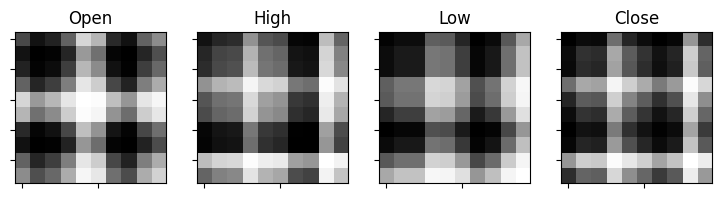

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True,
                                    figsize=(9, 2))
for i in range(4):
  axes[i].set_title(data.columns[i])
  axes[i].imshow(gasf_simples[0][:, :, i], cmap=cm.Greys_r)
  axes[i].set_yticklabels([])
  axes[i].set_xticklabels([])

Now it's time to detect the pattern in each simple using the methods we've used so far :



In [157]:
def detect_pattern(portion):
  
  df = pd.DataFrame({'Open' : portion[:, 0],
                     'High' : portion[:, 1],
                     'Low' : portion[:, 2],
                     'Close' : portion[:, 3],})
  
  df = process_data(df, slope=True)
  df = process_data(df, slope=False)

  df = detect_evening_star(df)
  df = detect_morning_star(df)
  df = detect_shooting_star(df)
  df = detect_hanging_man(df)
  df = detect_bullish_engulfing(df)
  df = detect_bearish_engulfing(df)
  df = detect_hammer(df)
  df = detect_inverted_hammer(df)
  df = detect_bullish_harami(df)
  df = detect_bearish_harami(df)

  result = [np.sum(df['evening']),
            np.sum(df['morning']),
            np.sum(df['shooting_star']),
            np.sum(df['hanging_man']),
            np.sum(df['bullish_engulfing']),
            np.sum(df['bearish_engulfing']),
            np.sum(df['hammer']),
            np.sum(df['inverted_hammer']),
            np.sum(df['bullish_harami']),
            np.sum(df['bearish_harami'])]

  return np.array(result)

Now let's prepare our data for the CNN model :

In [158]:
def prepare_data(data):
  portions = get_windows(data)
  gsf_simples = get_GASF(portions)
  labels = []
  for p in portions:
    labels.append(np.argmax(detect_pattern(p)))
  return gsf_simples, np.array(labels)

It can take about an hour to prepare the data, but fortunately I have already prepared it and divided it into two parts, one for training and one for testing.
Let's try it in a small part of the data to demonstrate:

In [159]:
X, y = prepare_data(data[:12])

100%|██████████| 10/10 [00:00<00:00, 491.86it/s]


[ Info ] : detecting evening star


0it [00:00, ?it/s]


[ Info ] : detecting morning star


  0%|          | 0/2 [00:00<?, ?it/s]


[ Info ] : detecting shooting star


0it [00:00, ?it/s]


[ Info ] : detecting hanging man


0it [00:00, ?it/s]


[ Info ] : detecting bullish engulfing


 50%|█████     | 1/2 [00:00<00:00, 1595.40it/s]


[ Info ] : detecting bearish engulfing


0it [00:00, ?it/s]


[ Info ] : detecting hammer


100%|██████████| 2/2 [00:00<00:00, 1802.45it/s]


[ Info ] : detecting inverted hammer


 50%|█████     | 1/2 [00:00<00:00, 970.01it/s]


[ Info ] : detecting bullish harami


 50%|█████     | 1/2 [00:00<00:00, 1164.76it/s]


[ Info ] : detecting bearish harami


0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 148.38it/s]


[ Info ] : detecting evening star


0it [00:00, ?it/s]


[ Info ] : detecting morning star


 33%|███▎      | 1/3 [00:00<00:00, 667.99it/s]


[ Info ] : detecting shooting star


0it [00:00, ?it/s]


[ Info ] : detecting hanging man


0it [00:00, ?it/s]


[ Info ] : detecting bullish engulfing


 67%|██████▋   | 2/3 [00:00<00:00, 2251.37it/s]


[ Info ] : detecting bearish engulfing


0it [00:00, ?it/s]


[ Info ] : detecting hammer


100%|██████████| 3/3 [00:00<00:00, 3752.73it/s]


[ Info ] : detecting inverted hammer


 67%|██████▋   | 2/3 [00:00<00:00, 985.16it/s]


[ Info ] : detecting bullish harami


 67%|██████▋   | 2/3 [00:00<00:00, 1792.05it/s]


[ Info ] : detecting bearish harami


0it [00:00, ?it/s]


# 7. The GAF-CNN model

## 7.1. Description

The authors of the paper expect that a GAF-CNN model can the computer to look at the candlestick patterns with as much nuance as a human trader unlike a traditional application of CNN.

In [224]:
from sklearn.metrics import confusion_matrix
import numpy as np
from keras import backend as K
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Activation

In the paper, the time series data based on opening, high, low, and closing prices (OHLC) in encoded to GASF matrices with the window size set to 10, so the shape of the data matrices will be (10, 10, 4). In this step, we will train this 3D matrices data with the CNN model described in the paper :

<center>

| Parameters | Values |
| --- | ----------- |
|epochs | 300 |
|batch size | 64 |
|optimizer | Adam |
|learning rate | 0.001 |
|beta 1 | 0.9 |
|beta 2 | 0.999 |
|early stopping | 20 epochs |

I am implemeting here a model similar to the one they have used in their github repository but with slight modifications.

In [230]:
model = Sequential()

model.add(Conv2D(16, (2, 2), input_shape=(10, 10, 4), padding='same', strides=(1, 1)))
model.add(Activation('sigmoid'))

model.add(Conv2D(16, (2, 2), padding='same', strides=(1, 1)))
model.add(Activation('sigmoid'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(9)) # The 9 patterns we are about to detect
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 10, 10, 16)        272       
                                                                 
 activation_9 (Activation)   (None, 10, 10, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        1040      
                                                                 
 activation_10 (Activation)  (None, 10, 10, 16)        0         
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               204928    
                                                                 
 dense_7 (Dense)             (None, 9)                

## 3.4. Training the model :

Because the given dataset is a bit tiny, and processing new data may take long, I will train the model on their data first, then use the Apple dataset for the test.

In [273]:
with open('/content/label8_eurusd_10bar_1500_500_val200_gaf_culr.pkl', 'rb') as f:
  datna  = pickle.load(f)

In [274]:
datna.keys()

dict_keys(['test_gaf', 'test_label_arr', 'val_label', 'test_data', 'train_label', 'train_gaf', 'train_data', 'test_label', 'val_gaf', 'train_label_arr', 'val_data', 'val_label_arr'])

In [284]:
datna["test_label_arr"].shape

(5000, 9)

In [285]:
len(df)

5034

In [259]:
with open(get_from_drive('1l718h4--lUWQwLecWJdvZT6Aq_-3_uz9', 'data.pkl'), 'rb') as f:
  data  = pickle.load(f)
X_train = data['X_train'][5]
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test_Apple = data['X_test_Apple']
y_test_Apple = data['y_test_Apple']

In [286]:
y_test_Apple = datna["test_label_arr"]

In [287]:
y_test_Apple

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [261]:
model.compile(loss='categorical_crossentropy', optimizer = optimizers.SGD(lr=0.01), metrics=['accuracy'])
hist = model.fit(x=X_train, y=y_train,
                 validation_data=(X_val, y_val),
                 batch_size=64, epochs=50, verbose=2)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


235/235 - 4s - loss: 1.5851 - accuracy: 0.4052 - val_loss: 1.3384 - val_accuracy: 0.4475 - 4s/epoch - 15ms/step
Epoch 2/50
235/235 - 2s - loss: 1.2337 - accuracy: 0.5455 - val_loss: 1.0991 - val_accuracy: 0.6470 - 2s/epoch - 10ms/step
Epoch 3/50
235/235 - 2s - loss: 1.0654 - accuracy: 0.6268 - val_loss: 1.0497 - val_accuracy: 0.6380 - 2s/epoch - 10ms/step
Epoch 4/50
235/235 - 2s - loss: 0.9542 - accuracy: 0.6669 - val_loss: 0.8990 - val_accuracy: 0.6710 - 2s/epoch - 10ms/step
Epoch 5/50
235/235 - 2s - loss: 0.8788 - accuracy: 0.6886 - val_loss: 0.8349 - val_accuracy: 0.6805 - 2s/epoch - 10ms/step
Epoch 6/50
235/235 - 2s - loss: 0.8250 - accuracy: 0.7092 - val_loss: 0.7795 - val_accuracy: 0.7100 - 2s/epoch - 10ms/step
Epoch 7/50
235/235 - 2s - loss: 0.7848 - accuracy: 0.7222 - val_loss: 0.7164 - val_accuracy: 0.7555 - 2s/epoch - 10ms/step
Epoch 8/50
235/235 - 2s - loss: 0.7556 - accuracy: 0.7337 - val_loss: 0.7001 - val_accuracy: 0.7445 - 2s/epoch - 10ms/step
Epoch 9/50
235/235 - 2s - l

In [263]:
def print_result(data, model):
    # get train & test pred-labels
    train_pred = model.predict(X_train).argmax(axis = 1)
    test_pred = model.predict(X_test_Apple).argmax(axis = 1)
    # get train & test true-labels
    train_label = y_train[:, 0]
    test_label = y_test_Apple[:, 0]
    # train & test confusion matrix
    train_result_cm = confusion_matrix(train_label, train_pred, labels=range(9))
    test_result_cm = confusion_matrix(test_label, test_pred, labels=range(9))

    print(train_result_cm, '\n', test_result_cm)

In [264]:
PARAMS = {}
PARAMS['pkl_name'] = '/content/label8_eurusd_10bar_1500_500_val200_gaf_culr.pkl'
PARAMS['model_name'] = './model/cnn_model_10bar.h5'
PARAMS['classes'] = 9
PARAMS['lr'] = 0.01
PARAMS['epochs'] = 50
PARAMS['batch_size'] = 64
PARAMS['optimizer'] = optimizers.SGD(lr=0.01)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Text(0.5, 1.0, 'Accuracy')

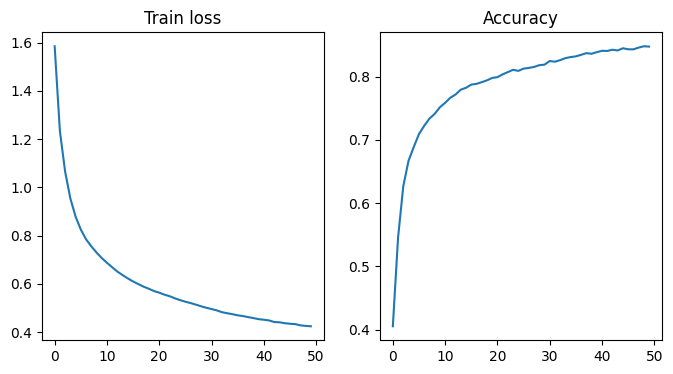

In [296]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("Train loss")
ax = plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.title("Accuracy")

In [300]:
print("Mean Absolute Error:", mean_absolute_error(reduction_y_test, reduction_Lstm_pred))
print('Mean Squared Error:', mean_squared_error(reduction_y_test, reduction_Lstm_pred))
print('Root Mean Squared Error:', sqrt(mean_squared_error(reduction_y_test, reduction_Lstm_pred)))
print("Coefficient of Determination:", r2_score(reduction_y_test, reduction_Lstm_pred))

In [301]:
xx.shape

(5017, 10, 10, 4)